In [1]:
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import spacy

from collections import Counter
from functools import partial
from gensim.corpora import Dictionary
from gensim.models import Phrases
from gensim.models.wrappers import LdaMallet
from tqdm import tqdm
from wordcloud import WordCloud

In [2]:
data_path = '../../data'
random_state = 10

# Listings

In [3]:
listings = pd.read_json(os.path.join(data_path, 'airbnb_listings.json'))
listings = listings.drop_duplicates(subset='id')
listings

,id,property_type_id,tier_id,name,bedrooms,beds,bathrooms,bedroom_label,bathroom_label,person_capacity,...,is_new_listing,room_and_property_type,room_type_category,room_type,space_type,preview_amenity_names,amenity_ids,content,rate,neighborhood
0,13301630,2.0,0,2 Beds in my San Diego Master Bedroom Suite.,1.0,1.0,1.0,1 bedroom,1 shared bath,5,...,False,Private room in house,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 3, 4, 5, 69, 8, 9, 15, 25, 27, 30, 31, ...","[1 bed, Private room, Private room in house]",35,NaN
1,46026275,37.0,0,Simple Bedroom + Private bathroom + parking,1.0,1.0,1.0,1 bedroom,1 private bath,2,...,True,Private room in condominium,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 4, 36, 5, 37, 39, 8, 40, 41, 9...","[1 bed, Private room, Private room in condomin...",30,[Linda Vista]
2,35774873,37.0,0,PERFECT STUDIO-DOWNTOWN LITTLE ITALY&PARKING SPOT,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 129, 2, 4, 5, 8, 9, 77, 85, 21, 86, 89, 90...","[1 bed, Entire condominium]",77,"[Core-Columbia, Downtown San Diego]"
3,8174032,1.0,0,Vacant bed for short stays,1.0,1.0,1.0,1 bedroom,1 bath,1,...,False,Private room in apartment,private_room,Private room,Private room,"[Wifi, Kitchen]","[2, 3, 35, 4, 36, 37, 38, 7, 39, 8, 41, 77, 21...","[1 bed, Private room, Private room in apartment]",25,[Point Loma Heights]
4,20881330,53.0,0,Beautiful Studio in the Heart of San Diego!,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire guest suite,entire_home,Entire home/apt,Entire guest suite,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 4, 5, 8, 9, 73, 77, 85, 86, 87, 23, 89, 90...","[1 bed, Entire guest suite]",67,"[Mid-City, Redwood Village, Rolando Park]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,42172804,37.0,0,Cozy Downtown Loft in a High-Rise!,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 36, 4, 5, 40, 8, 9, 44, 45, 46...","[1 bed, Entire condominium]",75,"[Core-Columbia, East Village]"
7316,21040786,38.0,0,"VOTED ""BEST VIEW"" - entire home - central loca...",2.0,6.0,2.0,2 bedrooms,2 baths,10,...,False,Entire bungalow,entire_home,Entire home/apt,Entire bungalow,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 4, 5, 8, 9, 12, 23, 27, 30, 31, 33, 34,...","[6 beds, Entire bungalow]",294,[MIddletown]
7317,31581094,2.0,0,The Alfred Mansion,5.0,8.0,4.5,5 bedrooms,4.5 baths,12,...,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 65, 1, 2, 4, 7, 72, 8, 73, 9, 74, 77, 85,...","[8 beds, Entire house]",728,[Hillcrest]
7318,18426407,2.0,0,Charming Hillcrest/Mission Hills 3 BR + House,3.0,4.0,2.0,3 bedrooms,2 baths,8,...,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 1, 4, 72, 8, 9, 77, 23, 89, 90, 91, 92, 9...","[4 beds, Entire house]",193,[Hillcrest]


Remove listings without neighborhoods

In [4]:
listings = listings[listings.neighborhood.notna()]
listings

,id,property_type_id,tier_id,name,bedrooms,beds,bathrooms,bedroom_label,bathroom_label,person_capacity,...,is_new_listing,room_and_property_type,room_type_category,room_type,space_type,preview_amenity_names,amenity_ids,content,rate,neighborhood
1,46026275,37.0,0,Simple Bedroom + Private bathroom + parking,1.0,1.0,1.0,1 bedroom,1 private bath,2,...,True,Private room in condominium,private_room,Private room,Private room,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 4, 36, 5, 37, 39, 8, 40, 41, 9...","[1 bed, Private room, Private room in condomin...",30,[Linda Vista]
2,35774873,37.0,0,PERFECT STUDIO-DOWNTOWN LITTLE ITALY&PARKING SPOT,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 129, 2, 4, 5, 8, 9, 77, 85, 21, 86, 89, 90...","[1 bed, Entire condominium]",77,"[Core-Columbia, Downtown San Diego]"
3,8174032,1.0,0,Vacant bed for short stays,1.0,1.0,1.0,1 bedroom,1 bath,1,...,False,Private room in apartment,private_room,Private room,Private room,"[Wifi, Kitchen]","[2, 3, 35, 4, 36, 37, 38, 7, 39, 8, 41, 77, 21...","[1 bed, Private room, Private room in apartment]",25,[Point Loma Heights]
4,20881330,53.0,0,Beautiful Studio in the Heart of San Diego!,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire guest suite,entire_home,Entire home/apt,Entire guest suite,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 4, 5, 8, 9, 73, 77, 85, 86, 87, 23, 89, 90...","[1 bed, Entire guest suite]",67,"[Mid-City, Redwood Village, Rolando Park]"
5,12855271,40.0,0,#4 UNIT #4 +A/C+Jacuzzi/self check-in after 4pm,1.0,2.0,1.0,1 bedroom,1 bath,4,...,False,Entire guesthouse,entire_home,Entire home/apt,Entire guesthouse,"[Wifi, Air conditioning]","[3, 4, 5, 101, 40, 43, 77, 47, 51, 54, 23, 25,...","[2 beds, Entire guesthouse]",32,"[Logan Heights, Memorial]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,42172804,37.0,0,Cozy Downtown Loft in a High-Rise!,0.0,1.0,1.0,Studio,1 bath,2,...,False,Entire condominium,entire_home,Entire home/apt,Entire condominium,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 33, 34, 35, 36, 4, 5, 40, 8, 9, 44, 45, 46...","[1 bed, Entire condominium]",75,"[Core-Columbia, East Village]"
7316,21040786,38.0,0,"VOTED ""BEST VIEW"" - entire home - central loca...",2.0,6.0,2.0,2 bedrooms,2 baths,10,...,False,Entire bungalow,entire_home,Entire home/apt,Entire bungalow,"[Wifi, Free parking, Kitchen, Air conditioning]","[1, 2, 4, 5, 8, 9, 12, 23, 27, 30, 31, 33, 34,...","[6 beds, Entire bungalow]",294,[MIddletown]
7317,31581094,2.0,0,The Alfred Mansion,5.0,8.0,4.5,5 bedrooms,4.5 baths,12,...,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 65, 1, 2, 4, 7, 72, 8, 73, 9, 74, 77, 85,...","[8 beds, Entire house]",728,[Hillcrest]
7318,18426407,2.0,0,Charming Hillcrest/Mission Hills 3 BR + House,3.0,4.0,2.0,3 bedrooms,2 baths,8,...,False,Entire house,entire_home,Entire home/apt,Entire house,"[Wifi, Free parking, Kitchen]","[64, 1, 4, 72, 8, 9, 77, 23, 89, 90, 91, 92, 9...","[4 beds, Entire house]",193,[Hillcrest]


# Reviews

In [5]:
reviews = pd.read_json(os.path.join(data_path, 'airbnb_reviews.json'))
reviews = reviews.drop_duplicates(subset='id')
reviews

,id,listing_id,author_id,recipient_id,rating,comments,created_at,language,response
0,653954608,13301630,328321073,40442827,5,magnificent,2020-08-20 22:48:25+00:00,en,NaN
1,629997649,13301630,328321073,40442827,5,I have been Garry's guest for the last 6 month...,2020-06-15 23:46:10+00:00,en,NaN
2,583538843,13301630,31735215,40442827,5,Gary is a wonderful host.\nHe is very nice and...,2019-12-29 00:59:02+00:00,en,NaN
3,318521505,13301630,212339508,40442827,5,Recommended to all for a cozy place with great...,2018-09-03 22:56:57+00:00,en,NaN
4,295091676,13301630,124868001,40442827,5,Gary was very friendly and welcoming! And the ...,2018-07-22 23:49:03+00:00,en,NaN
...,...,...,...,...,...,...,...,...,...
426202,426354473,28319097,18324884,3808442,5,"I had a great stay, the house was super clean,...",2019-03-20 22:27:36+00:00,en,NaN
426203,402227519,28319097,46016736,3808442,3,Location is great and host is wonderful.\nRoom...,2019-01-17 23:23:48+00:00,en,NaN
426204,366547778,28319097,74203189,3808442,5,Very calm and relaxing room and located at a c...,2019-01-02 23:41:15+00:00,en,NaN
426205,365733179,28319097,120325436,3808442,5,As beautiful as shown in the photos! Cute yard...,2019-01-01 21:10:33+00:00,en,NaN


Filter out non-English reviews

In [6]:
reviews = reviews[reviews.language=='en']
reviews

,id,listing_id,author_id,recipient_id,rating,comments,created_at,language,response
0,653954608,13301630,328321073,40442827,5,magnificent,2020-08-20 22:48:25+00:00,en,NaN
1,629997649,13301630,328321073,40442827,5,I have been Garry's guest for the last 6 month...,2020-06-15 23:46:10+00:00,en,NaN
2,583538843,13301630,31735215,40442827,5,Gary is a wonderful host.\nHe is very nice and...,2019-12-29 00:59:02+00:00,en,NaN
3,318521505,13301630,212339508,40442827,5,Recommended to all for a cozy place with great...,2018-09-03 22:56:57+00:00,en,NaN
4,295091676,13301630,124868001,40442827,5,Gary was very friendly and welcoming! And the ...,2018-07-22 23:49:03+00:00,en,NaN
...,...,...,...,...,...,...,...,...,...
426201,429380823,28319097,67823416,3808442,3,"For me, beautiful house but the communication ...",2019-03-27 22:34:40+00:00,en,"Philippe,\nYou asked to leave your bike/luggag..."
426202,426354473,28319097,18324884,3808442,5,"I had a great stay, the house was super clean,...",2019-03-20 22:27:36+00:00,en,NaN
426203,402227519,28319097,46016736,3808442,3,Location is great and host is wonderful.\nRoom...,2019-01-17 23:23:48+00:00,en,NaN
426204,366547778,28319097,74203189,3808442,5,Very calm and relaxing room and located at a c...,2019-01-02 23:41:15+00:00,en,NaN


Remove empty reviews

In [7]:
reviews = reviews[reviews.comments.notna()]
reviews

,id,listing_id,author_id,recipient_id,rating,comments,created_at,language,response
0,653954608,13301630,328321073,40442827,5,magnificent,2020-08-20 22:48:25+00:00,en,NaN
1,629997649,13301630,328321073,40442827,5,I have been Garry's guest for the last 6 month...,2020-06-15 23:46:10+00:00,en,NaN
2,583538843,13301630,31735215,40442827,5,Gary is a wonderful host.\nHe is very nice and...,2019-12-29 00:59:02+00:00,en,NaN
3,318521505,13301630,212339508,40442827,5,Recommended to all for a cozy place with great...,2018-09-03 22:56:57+00:00,en,NaN
4,295091676,13301630,124868001,40442827,5,Gary was very friendly and welcoming! And the ...,2018-07-22 23:49:03+00:00,en,NaN
...,...,...,...,...,...,...,...,...,...
426201,429380823,28319097,67823416,3808442,3,"For me, beautiful house but the communication ...",2019-03-27 22:34:40+00:00,en,"Philippe,\nYou asked to leave your bike/luggag..."
426202,426354473,28319097,18324884,3808442,5,"I had a great stay, the house was super clean,...",2019-03-20 22:27:36+00:00,en,NaN
426203,402227519,28319097,46016736,3808442,3,Location is great and host is wonderful.\nRoom...,2019-01-17 23:23:48+00:00,en,NaN
426204,366547778,28319097,74203189,3808442,5,Very calm and relaxing room and located at a c...,2019-01-02 23:41:15+00:00,en,NaN


Remove automated postings about trip cancellations

In [8]:
automated_review = reviews.comments.apply(lambda x: 'This is an automated posting.' in x)
reviews = reviews[~automated_review]
reviews

,id,listing_id,author_id,recipient_id,rating,comments,created_at,language,response
0,653954608,13301630,328321073,40442827,5,magnificent,2020-08-20 22:48:25+00:00,en,NaN
1,629997649,13301630,328321073,40442827,5,I have been Garry's guest for the last 6 month...,2020-06-15 23:46:10+00:00,en,NaN
2,583538843,13301630,31735215,40442827,5,Gary is a wonderful host.\nHe is very nice and...,2019-12-29 00:59:02+00:00,en,NaN
3,318521505,13301630,212339508,40442827,5,Recommended to all for a cozy place with great...,2018-09-03 22:56:57+00:00,en,NaN
4,295091676,13301630,124868001,40442827,5,Gary was very friendly and welcoming! And the ...,2018-07-22 23:49:03+00:00,en,NaN
...,...,...,...,...,...,...,...,...,...
426201,429380823,28319097,67823416,3808442,3,"For me, beautiful house but the communication ...",2019-03-27 22:34:40+00:00,en,"Philippe,\nYou asked to leave your bike/luggag..."
426202,426354473,28319097,18324884,3808442,5,"I had a great stay, the house was super clean,...",2019-03-20 22:27:36+00:00,en,NaN
426203,402227519,28319097,46016736,3808442,3,Location is great and host is wonderful.\nRoom...,2019-01-17 23:23:48+00:00,en,NaN
426204,366547778,28319097,74203189,3808442,5,Very calm and relaxing room and located at a c...,2019-01-02 23:41:15+00:00,en,NaN


# Merge Data

In [9]:
df = listings[['id', 'neighborhood']].copy()
df = df.merge(reviews[['listing_id', 'comments', 'rating']], left_on='id', right_on='listing_id')
df

,id,neighborhood,listing_id,comments,rating
0,35774873,"[Core-Columbia, Downtown San Diego]",35774873,Loved staying in this adorable Studio in the h...,5
1,35774873,"[Core-Columbia, Downtown San Diego]",35774873,"Brookes studio was in perfect location, right ...",5
2,35774873,"[Core-Columbia, Downtown San Diego]",35774873,This studio is perfect! It has everything you ...,5
3,35774873,"[Core-Columbia, Downtown San Diego]",35774873,Brooke is a great host! So kind and helpful an...,5
4,35774873,"[Core-Columbia, Downtown San Diego]",35774873,Brooke is the epitome of the hostess with the ...,5
...,...,...,...,...,...
358871,43486316,[Hillcrest],43486316,Wonderful place close to great amenities! The ...,5
358872,43486316,[Hillcrest],43486316,Rick is an AMAZING host. The place is so clos...,5
358873,43486316,[Hillcrest],43486316,Very beautiful home. Nice hot tub would stay a...,5
358874,43486316,[Hillcrest],43486316,This space is everything it advertises and the...,5


In [10]:
df = df.explode('neighborhood')
df

,id,neighborhood,listing_id,comments,rating
0,35774873,Core-Columbia,35774873,Loved staying in this adorable Studio in the h...,5
0,35774873,Downtown San Diego,35774873,Loved staying in this adorable Studio in the h...,5
1,35774873,Core-Columbia,35774873,"Brookes studio was in perfect location, right ...",5
1,35774873,Downtown San Diego,35774873,"Brookes studio was in perfect location, right ...",5
2,35774873,Core-Columbia,35774873,This studio is perfect! It has everything you ...,5
...,...,...,...,...,...
358871,43486316,Hillcrest,43486316,Wonderful place close to great amenities! The ...,5
358872,43486316,Hillcrest,43486316,Rick is an AMAZING host. The place is so clos...,5
358873,43486316,Hillcrest,43486316,Very beautiful home. Nice hot tub would stay a...,5
358874,43486316,Hillcrest,43486316,This space is everything it advertises and the...,5


Identify neighborhoods with more than 5000 reviews

In [11]:
neighborhood_counts = df.groupby('neighborhood')['comments'].count()
neighborhood_counts = neighborhood_counts[neighborhood_counts>5000]
neighborhoods = set(neighborhood_counts.index)
neighborhoods

{'Bankers Hill',
 'City Heights',
 'Clairemont',
 'Core-Columbia',
 'East Village',
 'Golden Hill',
 'Hillcrest',
 'La Jolla',
 'Little Italy',
 'Logan Heights',
 'MIddletown',
 'Mid-City',
 'Mission Beach',
 'Mission Hills',
 'Normal Heights',
 'North Park',
 'Ocean Beach',
 'Pacific Beach',
 'Park West',
 'Point Loma',
 'Point Loma Heights',
 'Sherman Heights',
 'South Park',
 'University Heights'}

Keep reviews from neighborhoods with more than 5000 reviews

In [12]:
df = df[df.neighborhood.isin(neighborhoods)].reset_index(drop=True)
df

,id,neighborhood,listing_id,comments,rating
0,35774873,Core-Columbia,35774873,Loved staying in this adorable Studio in the h...,5
1,35774873,Core-Columbia,35774873,"Brookes studio was in perfect location, right ...",5
2,35774873,Core-Columbia,35774873,This studio is perfect! It has everything you ...,5
3,35774873,Core-Columbia,35774873,Brooke is a great host! So kind and helpful an...,5
4,35774873,Core-Columbia,35774873,Brooke is the epitome of the hostess with the ...,5
...,...,...,...,...,...
328503,43486316,Hillcrest,43486316,Wonderful place close to great amenities! The ...,5
328504,43486316,Hillcrest,43486316,Rick is an AMAZING host. The place is so clos...,5
328505,43486316,Hillcrest,43486316,Very beautiful home. Nice hot tub would stay a...,5
328506,43486316,Hillcrest,43486316,This space is everything it advertises and the...,5


# Process Reviews

In [13]:
nlp = spacy.load('en_core_web_sm')

In [14]:
def keep_token(token):
    return token.is_alpha and not token.is_stop

def process_token(token):
    lemma = token.lemma_.lower() if token.lemma_ != '-PRON-' else token.lower_
    return lemma.strip()

def process_doc(doc):
    return [process_token(token) for token in doc if keep_token(token)]

def process_corpus(corpus, n_process=1, batch_size=100):
    processed_corpus = [None] * len(corpus)
    corpus_iter = tqdm(corpus, position=0)
    
    for i, doc in enumerate(nlp.pipe(corpus_iter, n_process=n_process, batch_size=batch_size)):
        processed_corpus[i] = process_doc(doc)
    
    return processed_corpus

Convert reviews to tokens, remove stop words, and lemmatize remaining words

In [15]:
df['comments_processed'] = process_corpus(df.comments, batch_size=100, n_process=4)

100%|██████████| 328508/328508 [10:44<00:00, 509.79it/s]


Find bigrams and trigrams

In [16]:
ngram_iter = 2
min_count = 20
corpus = df.comments_processed.values

for i in range(ngram_iter):
    phrases = Phrases(corpus, min_count=min_count)
    corpus = phrases[corpus]

df['comments_ngrams'] = [doc for doc in corpus]

Find some of the most common words in the corpus. Number selected to obtain meaningful word clouds.

In [17]:
corpus_counts = Counter(word for doc in df.comments_ngrams for word in set(doc))
common_words = {item[0] for item in corpus_counts.most_common(21)}
common_words

{'beach',
 'clean',
 'close',
 'comfortable',
 'definitely',
 'easy',
 'good',
 'great',
 'home',
 'host',
 'house',
 'location',
 'love',
 'need',
 'nice',
 'perfect',
 'place',
 'san_diego',
 'space',
 'stay',
 'time'}

Filter out the most common words

In [18]:
df['comments_filter'] = df.comments_ngrams.apply(lambda doc: [word for word in doc if word not in common_words])

# Word Clouds

In [19]:
def word_cloud(freq, title=None, random_state=None):
    wc = WordCloud(background_color='white', random_state=random_state)
    cloud = wc.generate_from_frequencies(freq)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    
    if title is not None:
        plt.title(title, fontsize=15)

Create word clouds by neighborhood

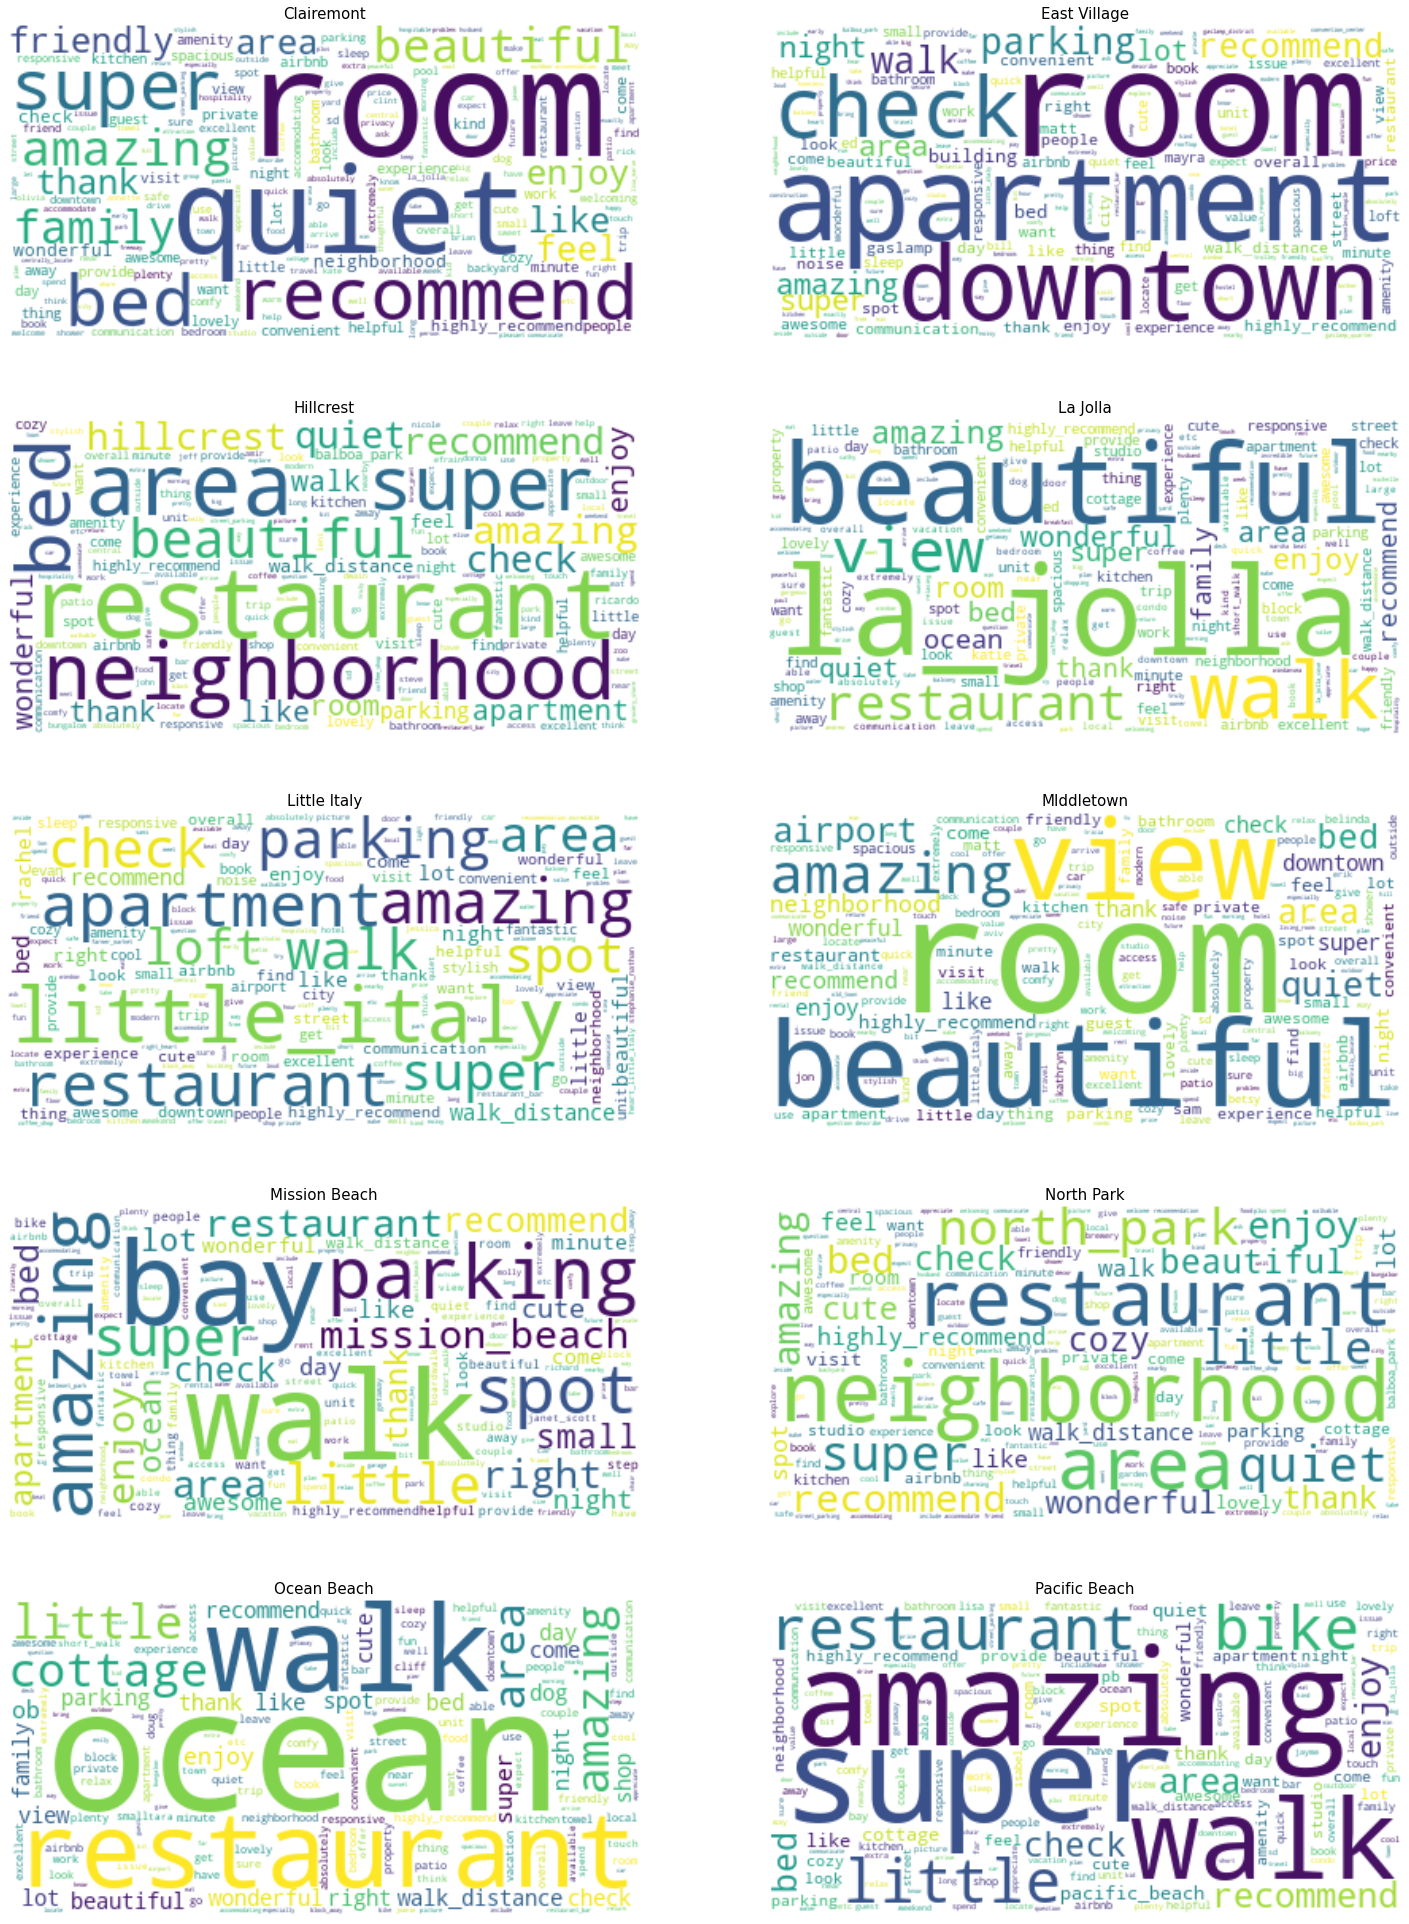

In [20]:
word_counts = {n: Counter(word for doc in df[df.neighborhood==n].comments_filter for word in doc) for n in neighborhoods}
neighborhoods_plot = {
    'Clairemont',
    'East Village',
    'Hillcrest',
    'La Jolla',
    'Little Italy',
    'MIddletown',
    'Mission Beach',
    'North Park',
    'Ocean Beach',
    'Pacific Beach'
}

ncols = 2
nrows = math.ceil(len(neighborhoods_plot) / ncols)
plt.figure(figsize=(25, 35))

for i, n in enumerate(sorted(neighborhoods_plot)):
    plt.subplot(nrows, ncols, i+1)
    word_cloud(word_counts[n], title=n, random_state=random_state)

Create word clouds by rating range

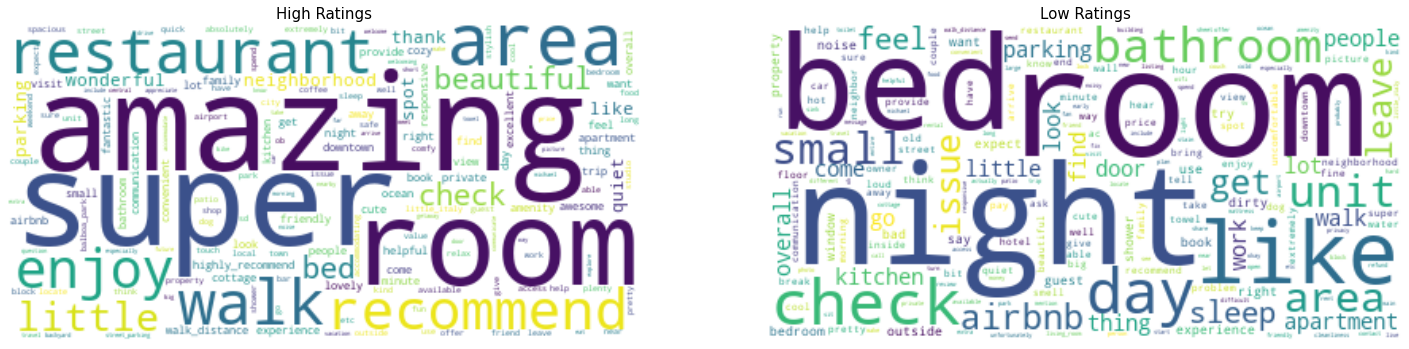

In [21]:
word_counts = {
    'high': Counter(word for doc in df[df.rating>3].comments_filter for word in doc),
    'low': Counter(word for doc in df[df.rating<=3].comments_filter for word in doc)
}

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
word_cloud(word_counts['high'], title='High Ratings', random_state=random_state)

plt.subplot(1, 2, 2)
word_cloud(word_counts['low'], title='Low Ratings', random_state=random_state)

# Topic Modeling
Convert reviews to a bag-of-words (BoW) format

In [22]:
dic = Dictionary(df.comments_ngrams)
dic.filter_extremes(no_below=20, no_above=0.3)
corpus = [dic.doc2bow(doc) for doc in df.comments_ngrams]

Train LDA model with [MALLET](http://mallet.cs.umass.edu/)

In [23]:
mallet_path = '/Users/klane/Downloads/mallet-2.0.8/bin/mallet'
num_topics = 10
workers = 4
iterations = 1000
optimize_interval = 100

lda = LdaMallet(
    mallet_path=mallet_path,
    corpus=corpus,
    id2word=dic,
    num_topics=num_topics,
    workers=workers,
    iterations=iterations,
    optimize_interval=optimize_interval,
    random_seed=random_state
)

Print resulting topics

In [24]:
def get_topic_words(i, num_words=10):
    return lda.print_topic(i, topn=num_words).split('"')[1::2]

In [25]:
for i in range(num_topics):
    print(get_topic_words(i))

['home', 'feel', 'lovely', 'beautiful', 'guest', 'wonderful', 'comfortable', 'welcoming', 'house', 'room']
['san_diego', 'close', 'apartment', 'area', 'downtown', 'minute', 'walk', 'locate', 'little_italy', 'airport']
['night', 'unit', 'issue', 'sleep', 'door', 'bit', 'noise', 'work', 'day', 'people']
['clean', 'super', 'nice', 'perfect', 'space', 'comfortable', 'love', 'cute', 'cozy', 'quiet']
['host', 'amazing', 'clean', 'highly_recommend', 'wonderful', 'recommend', 'helpful', 'responsive', 'comfortable', 'excellent']
['time', 'san_diego', 'airbnb', 'experience', 'visit', 'trip', 'day', 'book', 'perfect', 'friend']
['bed', 'kitchen', 'parking', 'small', 'bathroom', 'provide', 'towel', 'bedroom', 'plenty', 'space']
['house', 'enjoy', 'family', 'love', 'area', 'view', 'patio', 'space', 'relax', 'nice']
['easy', 'good', 'check', 'clean', 'room', 'nice', 'communication', 'host', 'access', 'recommend']
['beach', 'restaurant', 'walk', 'ocean', 'cottage', 'walk_distance', 'shop', 'close', '

Select number of topic words based on maximum topic overlap

In [26]:
num_words = 25
topics = {i: set(get_topic_words(i, num_words=num_words)) for i in range(num_topics)}
topic_overlap = [len(topics[i].intersection(topics[j])) for i in range(num_topics) for j in range(i+1, num_topics)]
print(f'Maximum topic overlap: {max(topic_overlap)} words')

Maximum topic overlap: 6 words


Get possible topics and scores for all reviews

In [27]:
df['topic'] = [topic for topic in lda.load_document_topics()]

Split topics and scores into separate columns

In [28]:
df_topics = df.copy().explode('topic')
df_topics[['topic', 'score']] = df_topics.topic.to_list()
df_topics

,id,neighborhood,listing_id,comments,rating,comments_processed,comments_ngrams,comments_filter,topic,score
0,35774873,Core-Columbia,35774873,Loved staying in this adorable Studio in the h...,5,"[love, stay, adorable, studio, heart, little, ...","[love, stay, adorable, studio, heart_little_it...","[adorable, studio, heart_little_italy, well, w...",0,0.087639
0,35774873,Core-Columbia,35774873,Loved staying in this adorable Studio in the h...,5,"[love, stay, adorable, studio, heart, little, ...","[love, stay, adorable, studio, heart_little_it...","[adorable, studio, heart_little_italy, well, w...",1,0.106063
0,35774873,Core-Columbia,35774873,Loved staying in this adorable Studio in the h...,5,"[love, stay, adorable, studio, heart, little, ...","[love, stay, adorable, studio, heart_little_it...","[adorable, studio, heart_little_italy, well, w...",2,0.050703
0,35774873,Core-Columbia,35774873,Loved staying in this adorable Studio in the h...,5,"[love, stay, adorable, studio, heart, little, ...","[love, stay, adorable, studio, heart_little_it...","[adorable, studio, heart_little_italy, well, w...",3,0.168109
0,35774873,Core-Columbia,35774873,Loved staying in this adorable Studio in the h...,5,"[love, stay, adorable, studio, heart, little, ...","[love, stay, adorable, studio, heart_little_it...","[adorable, studio, heart_little_italy, well, w...",4,0.131693
...,...,...,...,...,...,...,...,...,...,...
328507,43486316,Hillcrest,43486316,"We needed a place to relax and get away, but s...",5,"[need, place, relax, away, close, amenity, pla...","[need, place, relax, away, close, amenity, pla...","[relax, away, amenity, exactly, dreamy, flower...",5,0.095744
328507,43486316,Hillcrest,43486316,"We needed a place to relax and get away, but s...",5,"[need, place, relax, away, close, amenity, pla...","[need, place, relax, away, close, amenity, pla...","[relax, away, amenity, exactly, dreamy, flower...",6,0.228571
328507,43486316,Hillcrest,43486316,"We needed a place to relax and get away, but s...",5,"[need, place, relax, away, close, amenity, pla...","[need, place, relax, away, close, amenity, pla...","[relax, away, amenity, exactly, dreamy, flower...",7,0.104065
328507,43486316,Hillcrest,43486316,"We needed a place to relax and get away, but s...",5,"[need, place, relax, away, close, amenity, pla...","[need, place, relax, away, close, amenity, pla...","[relax, away, amenity, exactly, dreamy, flower...",8,0.073161


Calculate the amount topic probabilities within each neighborhood deviate from the expected probabilities

In [29]:
neighborhood_sum = df_topics.groupby(['neighborhood', 'topic'])['score'].sum()
neighborhood_pct = neighborhood_sum / neighborhood_sum.groupby('neighborhood').sum()

topic_sum = df_topics.groupby('topic')['score'].sum()
topic_pct = topic_sum / topic_sum.sum()

neighborhood_diff = neighborhood_pct - topic_pct
neighborhood_diff

neighborhood        topic
Bankers Hill        0        0.008479
                    1        0.009981
                    2        0.014501
                    3       -0.006737
                    4       -0.005468
                               ...   
University Heights  5        0.001968
                    6        0.000388
                    7       -0.006865
                    8       -0.000448
                    9       -0.010829
Name: score, Length: 240, dtype: float64

Find either the most above-average topic for each neighborhood or all above-average topics

In [30]:
above_average = True

if above_average:
    topics = neighborhood_diff > 0
else:
    topics = neighborhood_diff.reset_index().groupby('neighborhood')['score'].idxmax()

neighborhood_topics = neighborhood_diff[topics].reset_index()
neighborhood_topics['words'] = neighborhood_topics.topic.apply(partial(get_topic_words, num_words=num_words))
neighborhood_topics

,neighborhood,topic,score,words
0,Bankers Hill,0,0.008479,"[home, feel, lovely, beautiful, guest, wonderf..."
1,Bankers Hill,1,0.009981,"[san_diego, close, apartment, area, downtown, ..."
2,Bankers Hill,2,0.014501,"[night, unit, issue, sleep, door, bit, noise, ..."
3,Bankers Hill,8,0.001010,"[easy, good, check, clean, room, nice, communi..."
4,City Heights,0,0.002086,"[home, feel, lovely, beautiful, guest, wonderf..."
...,...,...,...,...
106,University Heights,1,0.001381,"[san_diego, close, apartment, area, downtown, ..."
107,University Heights,3,0.002889,"[clean, super, nice, perfect, space, comfortab..."
108,University Heights,4,0.001737,"[host, amazing, clean, highly_recommend, wonde..."
109,University Heights,5,0.001968,"[time, san_diego, airbnb, experience, visit, t..."


In [31]:
filename = os.path.join(data_path, 'airbnb_review_topics.json')
columns = ['neighborhood', 'topic', 'words']
topic_dict = neighborhood_topics[columns].to_dict(orient='records')

with open(filename, 'w') as f:
    print(json.dumps(topic_dict, indent=4), file=f)